# Lab 3: Spectral indices and transformations

In [311]:
from datetime import date
today = date.today()
d2 = today.strftime("%B %d, %Y")
print("Updated by Alfonso Torres-Rua, ", d2)

Updated by Alfonso Torres-Rua,  January 18, 2020


## Purpose: 
The purpose of this lab is to give you a tour of spectral indices that can be used to enhance phenomena of interest in remotely sensed images.  You will be introduced to methods for creating vegetation, water, snow, bare and burned area indices.  You will explore the Tasseled-cap and principal components transforms.  At the completion of the lab, you will be able to implement spectral indices and transforms to accentuate the information of interest in your study area.

Prerequisites: Lab 3

### Spectral indices
Spectral indices are based on the fact that reflectance spectra of different land covers are different.  The indices are designed to exploit these differences to accentuate particular land cover types.  Consider the following chart of reflectance spectra for various targets:

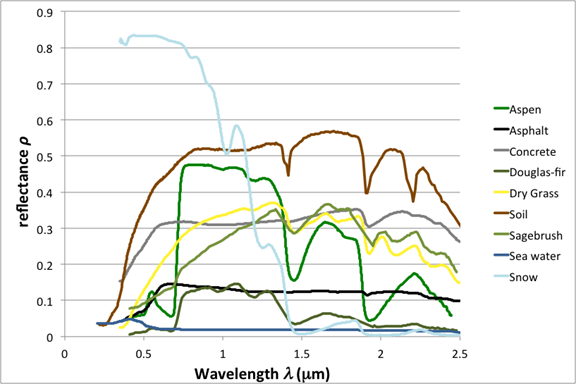

Observe that the land covers are separable at one or more wavelengths.  Note, in particular, that vegetation curves (green) have relatively high reflectance in the NIR range, where radiant energy is scattered by cell walls ([Bowker et al. 1985](http://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19850022138.pdf)).  Also note that vegetation has low reflectance in the red range, where radiant energy is [absorbed by chlorophyll](https://en.wikipedia.org/wiki/Chlorophyll#/media/File:Chlorophyll_ab_spectra-en.svg).  These observations motivate the formulation of vegetation indices, for example:

### -NDVI.  
The Normalized Difference Vegetation Index (NDVI) has a [long history](https://en.wikipedia.org/wiki/Normalized_Difference_Vegetation_Index) in remote sensing.  The typical formulation is

NDVI = (NIR - red) / (NIR + red)

Where NIR and red refer to reflectance, radiance or DN at the respective wavelength.  Implement indices of this form in Earth Engine with the normalizedDifference() method.  First, get an image of interest by drawing a Point named point, importing the Landsat 8 Collection 1 TOA as landsat8 and sorting the collection by cloud cover metadata:


In [312]:
# Initializing display and earthengine
from IPython.display import Image
%matplotlib inline

import ee
ee.Initialize()

In [313]:
# importing ipygee for dynamic mapping
from ipygee import *

In [314]:
# Define a location of interest as a point at SFO airport.
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="a.torres@aggiemail.usu.edu") #put your email here
address, (latitude, longitude) = geolocator.geocode("Logan, UT")
print(latitude, longitude)

point = ee.Geometry.Point([longitude, latitude])

41.7313447 -111.8348631


In [315]:
landsat8 =ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")

image = ee.Image(landsat8
    .filterBounds(point)
    .filterDate('2015-06-01', '2015-09-01')
    .sort('CLOUD_COVER')
    .first())

image = image.multiply(0.0001)

trueColor = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}

print(image.bandNames().getInfo())

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'B11', 'sr_aerosol', 'pixel_qa', 'radsat_qa']


In [316]:
Map = Map() # from ipygee
Map.show()

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

In [317]:
# add layer
Map.addLayer(image, trueColor, name='Landsat8 Image')
# zoom to the image
bounds = point.buffer(100)
Map.centerObject(bounds)

The NDVI computation is one line:


In [318]:
 ndvi = image.normalizedDifference(['B5', 'B4'])


Display the NDVI image with a color palette (feel free to make a better one):

In [319]:
vegPalette = ['white','red','yellow', 'green','blue']
Map.addLayer(ndvi, {min: 0, max: 1, 'palette': vegPalette},name = 'NDVI')


In [320]:
# color ramp based on hexadecimal values:
import seaborn as sns
pal = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95)
palette =pal.as_hex()

Map.addLayer(ndvi, {min: 0, max: 1, 'palette': palette},name = 'NDVI hexadecimal')


### -EVI.  
The Enhanced Vegetation Index (EVI) is designed to minimize saturation and background effects in NDVI ([Huete et al. 2002](https://www.sciencedirect.com/science/article/abs/pii/S0034425702000962).  Since it is not a normalized difference index, compute it with [an expression](https://developers.google.com/earth-engine/image_math#expressions):


In [321]:
evi = image.expression(
    '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
      'NIR': image.select('B5'),
      'RED': image.select('B4'),
      'BLUE': image.select('B2')
})


Observe that bands are referenced with the help of [an object](https://developer.mozilla.org/en-US/docs/Web/JavaScript/Guide/Grammar_and_Types#Object_literals) that is passed as the second argument to image.expression().  Display EVI:

In [322]:
Map.addLayer(evi, {min: -1, max: 1, 'palette': vegPalette}, 'EVI')

Compare EVI to NDVI.  What do you observe?

### -NDWI.  
The Normalized Difference Water Index (NDWI) was developed by Gao (1996) as an index of vegetation water content:

NDWI = (NIR - SWIR) / (NIR + SWIR)

Compute NDWI in Earth Engine with:


In [323]:
ndwi = image.normalizedDifference(['B5', 'B3'])

And display:

In [324]:
waterPalette = ['white', 'blue']
Map.addLayer(ndwi, {min: -0.5, max: 1, 'palette': waterPalette}, 'NDWI')


Note that this is not an exact implementation of NDWI, according to the OLI spectral response, since OLI does not have a band in the right position (1.26 𝛍m).

### -NDBSI.  
The Normalized Difference Bare Soil Index (NDBSI) aids in the differentiation of no vegetation locations:

NDBI = ((SWIR + RED) - (NIR + BLUE)) / ((SWIR + RED) + (NIR + BLUE))


In [325]:
b6b4 = image.select('B6').add(image.select('B4'))
b5b2 = image.select('B5').add(image.select('B2'))
ndbi = b5b2.subtract(b6b4).divide(b5b2.add(b6b4))#normalized difference bare soil index

barePalette = waterPalette = [ 'blue','white']

Map.addLayer(ndbi, {min: -1, max: 1, 'palette': vegPalette}, 'NDBI')


### -BAI.  
The Burned Area Index (BAI) was developed by [Chuvieco et al. (2002)](https://www.tandfonline.com/doi/abs/10.1080/01431160210153129) to assist in the delineation of burn scars and assessment of burn severity.  It is based on the spectral distance to charcoal reflectance.  To examine burn indices, load an image from 2013 showing the [Rim fire](https://en.wikipedia.org/wiki/Rim_Fire) in the Sierra Nevadas:


In [326]:
burnImage = ee.Image(landsat8
    .filterBounds(ee.Geometry.Point(-120.083, 37.850))
    .filterDate('2013-08-17', '2013-09-27')
    .sort('CLOUD_COVER')
    .first())

burnImage = burnImage.multiply(0.0001)   

Map.addLayer(burnImage, trueColor, 'burn image')

Closely examine the true color display of this image.  Can you spot the fire?  If not, the BAI may help.  As with EVI, use an expression to compute BAI in Earth Engine:

In [327]:
bai = burnImage.expression(
    '1.0 / ((0.1 - RED)**2 + (0.06 - NIR)**2)', {
      'NIR': burnImage.select('B5'),
      'RED': burnImage.select('B4'),
})


Display the result.  The burn area should be more obvious in the BAI visualization.

In [328]:
imgMax = bai.reduceRegion(
  reducer= ee.Reducer.max(),
  geometry=bai.geometry(),
  scale=30,
  maxPixels= 2.1E9
)

print ('Max value:', imgMax.getInfo())

Max value: {'constant': 9999999.999999844}


In [329]:
burnPalette = ['green', 'blue', 'yellow', 'red']
Map.addLayer(bai, {}, 'BAI')


### -NDSI.  
The Normalized Difference Snow Index (NDSI) was designed to estimate the amount of a pixel covered in snow ([Riggs et al. 1994](https://ieeexplore.ieee.org/document/399618/)):

NDSI = (green - SWIR) / (green + SWIR)

First, find a snow covered scene to test the index:


In [330]:
snowImage = ee.Image(landsat8
    .filterBounds(ee.Geometry.Point(-120.0421, 39.1002))
    .filterDate('2013-11-01', '2014-05-01')
    .sort('CLOUD_COVER')
    .first())
snowImage = snowImage.multiply(0.0001)    

Map.addLayer(snowImage, trueColor, 'snow image')


Compute and display NDSI in Earth Engine:

In [331]:
ndsi = snowImage.normalizedDifference(['B3', 'B6'])

snowPalette = ['red', 'green', 'blue', 'white']
Map.addLayer(ndsi, {min: -0.5, max: 0.5, 'palette': snowPalette}, 'NDSI')